##Intro:
So at high level variational inference is easy: all we need to do is define a guide and compute gradients of the ELBO.

$ELBO ≡ E_{q_{\phi}(z)}[logp_{\theta}(x,z)−logq_{\phi}(z)]$. 

$logp_{\theta}(x)\geq ELBO$.

$logp_{\theta}(x)−ELBO=KL(q_{\phi}(z)‖p_{\theta}(z|x))$

In [62]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as pyplot
import scipy.stats
import numpy as np

data = []
for _ in range(60):
    data.append(torch.tensor(1.0))
for _ in range(40):
    data.append(torch.tensor(1.0))

In [63]:
def model(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    ##sample from beta prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    #print(f)
    #loop over the observed data:
    for i in range(len(data)):
        #observe datapoints with bernoulli:
        pyro.sample('obs_{0}'.format(i), dist.Bernoulli(f), obs=data[i])

In [64]:
def guide(data):
    #Register two variational parameters with Pyro.
    alpha_q = pyro.param('alpha_q', torch.tensor(15.0), constraint = constraints.positive)
    beta_q = pyro.param('beta_q', torch.tensor(15.0), constraint = constraints.positive)
    return pyro.sample('latent_fairness', dist.Beta(alpha_q, beta_q))

In [65]:
adam_params = {'lr':0.0005, 'betas':(0.9, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
n_steps = 5000

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
#n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

..................................................

In [66]:
#extract the learned parameters:
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()

#use properties of Beta Dist to find the mean and std of the latent variable:
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print('\nbased on the data and prior belief, the fairness ' + 
      'of the coin is {0:.3f} +- {1:.3}'.format(inferred_mean, inferred_std))


based on the data and prior belief, the fairness of the coin is 0.908 +- 0.0396


In [67]:
posterior = dist.Beta(alpha_q, beta_q)
posterior_samples = posterior.sample(sample_shape = (1000,))

Text(0,0.5,'probability distribution')

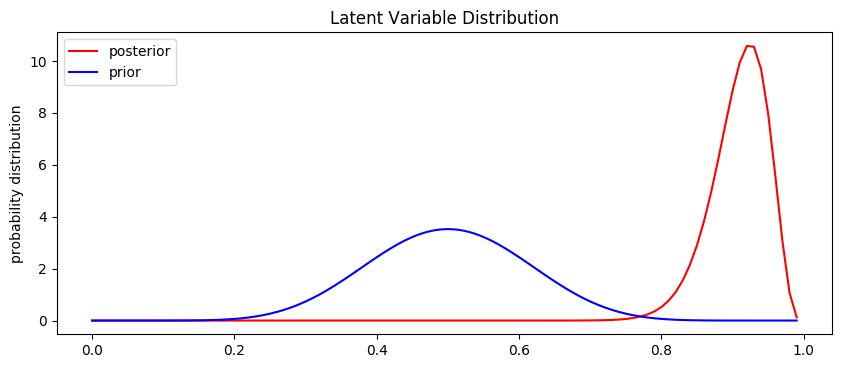

In [68]:
#plot distributions:
X = np.arange(0,1,0.01)
Prior = scipy.stats.beta.pdf(X, 10, 10)
Posterior = scipy.stats.beta.pdf(X, alpha_q, beta_q)

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Posterior, 'r-', label= 'posterior')
pyplot.plot(X, Prior, 'b-', label = 'prior')
pyplot.legend(loc='best')
pyplot.title('Latent Variable Distribution')
pyplot.ylabel('probability distribution')